# Style Transfer notebook
## CS152 October 10, 2018  Neil Rhodes

We look at Neural Style Transfer (transferring the style of one image to the content of another) as defined in [*Image Style Transfer Using Convolutional Neural Networks* by Gatys, Ecker, and Bethge, 2016](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

Code based on [fastai style transfer notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb).

In [16]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We are interested in doing style transfer. We want to take a given image and recast it in the style of some other image.


In [17]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *

from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path

## Utility Functions

In [18]:
def denorm(tensor, denormalizer):
    """Does the opposite of the transformation from tfms_from_model"""
    
    # Even though the transformer returned from tfms_from_model moves the channels
    # (from width, height, depth) to (1, channels, width, height), the denormalizer
    # returned from tfms_from_model doesn't convert back
    wid_height_depth = np.moveaxis(to_np(tensor),1,-1)[0]
    return denormalizer(wid_height_depth)

In [19]:
def draw_with_size(image, size_in_inches):
    plt.figure(figsize=(size_in_inches, size_in_inches))
    plt.imshow(image);

In [20]:
def random_image(shape):
    return np.random.uniform(0, 1, size=shape).astype(np.float32)

In [21]:
def scale_match(src, targ):
    """Returns the targ image resized so that its at exactly as big as src, while maintaining its aspect ratio.
    This may mean that the right or the bottom may be cropped."""
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    ratio = max(h/sh,w/sw);
    res = cv2.resize(targ, (int(sw*ratio), int(sh*ratio)))
    return res[:h,:w]

# Converting a random image to resemble the content of another image

The content image we'll be working with is a picture of the front of my house.  We'll be using the vgg16 network with images at a size of 288x288.

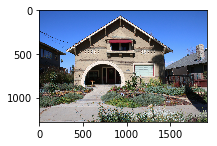

In [22]:
PATH = Path('../images')
HOUSE = 'house.png'
ARCH=vgg16
sz=288
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)

We'll be using PyTorch APIs in this lesson for the most part, rather than the fastai wrappers around them.
We get a vgg16 precomputed mode, move it onto the GPU, and mark it as non-trainable.

In [23]:
model_full = to_gpu(ARCH(True)).eval()
set_trainable(model_full, False)

We must create transformation functions that will:
* Resize the image to the request size
* Normalize the inputs
* Change to PyTorch ordering (channels first, rather than channels last)

We apply the transformation to the content image and see that the resulting shape has the number of channels first, and then has the request width and height.

In [24]:
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

Create a random image (the same size as the content)

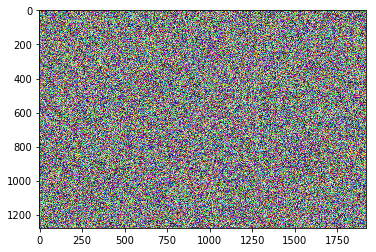

In [25]:
opt_img = random_image(content_img.shape)
plt.imshow(opt_img);

Apply the model transformation to the random image, and then create a PyTorch Variable from it, requesting gradients for the image.

In [26]:
opt_tfmd_img = val_tfms(opt_img)
opt_img_v = V(opt_tfmd_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

Let's look at the model.

In [27]:
model_full

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

We see that there are 43 layers. Let's create a new model (network) based on 
the first 37 layers.

In [28]:
model = nn.Sequential(*children(model_full)[:37])


We'll use VV, which creates a volatile Tensor: one which doesn't need gradients. Our goal is to find the activations at the 37th layer of vgg16 when appliced to the content image.  We'll save those activations and use those to compute the content loss.

Calling ```model``` with our input will return the corresponding output (which is 1x512x18x18, representing:
* 1 input example
* 512 features
* 18 width
* 18 height

In [29]:
targ_t = model(VV(content_tfmd_img[None]))
targ_t.shape

torch.Size([1, 512, 18, 18])

We'll set how many iterations to optimize, as well as the rate at which we print status information.

The optimizer we use is LBFGS. We pass in an iterable of the parameters we want to optimize, along with a learning rate.


In [30]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.6)

Our content loss function is fairly straightforward.  Do a Mean Square Error computation on:
* The output of the model given x as the input
* The saved output of the model (```targ_t```) given the content image as the input 

In [31]:
def content_loss(x): return F.mse_loss(model(x), targ_t)*1000


We define a step function that takes a loss function as input.  We zero out the gradients, call the loss function, then
do backwards propagation. 

In [32]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss


We run the optimizer step function 1000 times. The parameter we pass in is a closure that does one step.
The call to ```partial``` does a partial evaluation of the ```step``` function; that is, it creates a new function which
is equivalent to calling ```step(content_loss)```.

In [33]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,content_loss))

Iteration: 100, loss: 0.7142540216445923
Iteration: 200, loss: 0.3469903767108917
Iteration: 300, loss: 0.23838107287883759
Iteration: 400, loss: 0.18873819708824158
Iteration: 500, loss: 0.1601981669664383
Iteration: 600, loss: 0.14165106415748596
Iteration: 700, loss: 0.1289263367652893
Iteration: 800, loss: 0.11884171515703201
Iteration: 900, loss: 0.11120131611824036
Iteration: 1000, loss: 0.10491596162319183


To view the optimized image, we extract it from the PyTorch variable (with ```.data```), and then call our ```denorm``` function that'll denormalize (the inverse of the normalization transform we do to input images).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


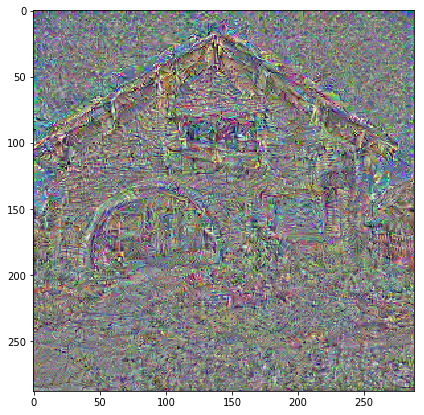

In [34]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Saving layers with hooks 

We've seen how we can get the activiations at a particular layer by creating a truncated version of the original model.  An alternative approach is to use a *hook* which will be called every time the module does its forward pass.

We define the ```SaveFeatures``` class which will save the activations in an instance variable called ```features```.

In [35]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

We calculate which layers in the model (Neural Network) are just before the MaxPool layers.  

In [36]:
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

We decide we want one of the later layers: 32, at index 3 in ```block_ends```. We use ```SaveFeatures``` to save the features in that layer.

In [37]:
sf = SaveFeatures(children(model_full)[block_ends[3]])

We define a function that'll return us a newly-initialized image to optimize, along with the optimizer that'll optimize that image.

In [38]:
def get_opt():
    opt_img = random_image(content_img.shape)
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We run the model on the (transformed) content image and save the activations for the layer of interest into ```targ_v```. Note that it is 512 features, each 36x36.

In [39]:
model(VV(content_tfmd_img[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

Our modified content loss function will now run the model on the input, and then extract the features from the saved layer.  We then do a Mean Squared Error loss calcuation with the just-extracted activations from the saved layer and the already-calculated activations from the same layer for the content(```targ_v```) .

In [40]:
def content_loss2(x):
    model(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

We run our optimizer 1000 times

In [41]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step, content_loss2))

Iteration: 100, loss: 0.29268017411231995
Iteration: 200, loss: 0.14440122246742249
Iteration: 300, loss: 0.10043444484472275
Iteration: 400, loss: 0.07889117300510406
Iteration: 500, loss: 0.06626226752996445
Iteration: 600, loss: 0.05812723934650421
Iteration: 700, loss: 0.052244383841753006
Iteration: 800, loss: 0.04772203043103218
Iteration: 900, loss: 0.04423169046640396
Iteration: 1000, loss: 0.041544508188962936


And, we display the optimized image. Using earlier layers would give us a more literal similarity to the original
(pixel-by-pixel).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


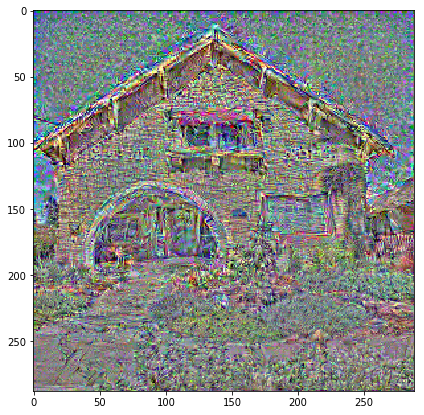

In [42]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

# Converting a random image to resemble the style of another image

The style picture we'l use is a painting by Monet.


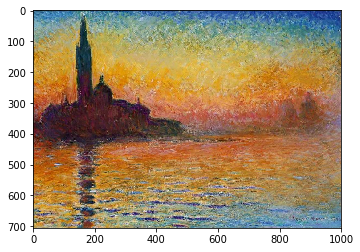

In [43]:
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);

We scale the style image so that it is the same size as the content.
We keep the same aspect ratio, but as you can see, we lose some of the bottom of the style image.

((1278, 1920, 3), (1278, 1920, 3))

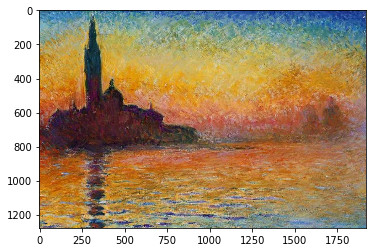

In [44]:
style = scale_match(content_img, style_img)
plt.imshow(style)
style.shape, content_img.shape

We obtain a new random image to optimize, along with its optimizer.

In [45]:
opt_img_v, optimizer = get_opt()

Rather than installing SaveFeatures on one layer of the model, as we did for the content matching, we install it
on all the models that end blocks.  That way, we'll have activations at layers throughout the network, ensuring 
that we can measure differences in both fine-grained style features, as well as larger features.

In [46]:
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

We run the content image through our model and save all our activations in ```targ_contents```. Note that this'll give us
the opportunity to decide in our loss function which layer we're actually interested in for our loss function.

In [47]:
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

We run the style image through our model and save all our activations in ```targ_styles```. 

In [48]:
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

We define the calculation of the gram matrix for a given input.  Note that we effectively calculate the dot-product of each of the flattened vectores.  Also note that we scale by 10^6. 

In [49]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

To calculate the style loss for an image, we run the image through our model, extract the activations at each saved layer,
and then calculate the gram_mse_losses for each of the layers. At the end, we return the total of all those losses.

In [50]:
def style_loss(x):
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

We run the optimizer for 1000 steps.

In [51]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 100, loss: 190.2854766845703
Iteration: 200, loss: 22.6854190826416
Iteration: 300, loss: 7.884485244750977
Iteration: 400, loss: 4.072549343109131
Iteration: 500, loss: 2.662984848022461
Iteration: 600, loss: 1.9896295070648193
Iteration: 700, loss: 1.614944577217102
Iteration: 800, loss: 1.3785035610198975
Iteration: 900, loss: 1.2151665687561035
Iteration: 1000, loss: 1.0952379703521729


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


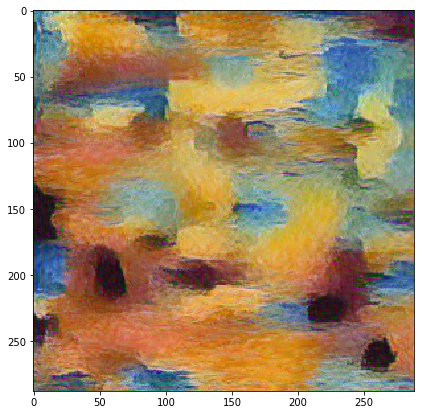

In [52]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Style Transfer

Now, we're ready to create an image that is close to the content of the content image, while also close to the style of the style image.

First, we get a fresh image and optimizer.

In [53]:
opt_img_v, optimizer = get_opt()

We save features for the layers of interest in the model.

In [54]:
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

We define a combined loss function.  Note that when calculating the content loss, we just use the activations at a specific index.
Also, note that we scale the content loss by a scaling factor.

In [55]:
def comb_loss(x):
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

We run the optimizer.

In [ ]:
n_iter=0
max_iter=1000
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 783.9486083984375
Iteration: 200, loss: 412.8153381347656
Iteration: 300, loss: 328.00445556640625
Iteration: 400, loss: 291.4024353027344
Iteration: 500, loss: 272.03692626953125
Iteration: 600, loss: 259.86407470703125
Iteration: 700, loss: 252.03506469726562
Iteration: 800, loss: 246.8732452392578
Iteration: 900, loss: 243.15884399414062


And draw the result.

In [ ]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)